Copyright (c) 2017,2018, Johannes Schöneberg. All rights reserved.
The default copyright laws apply.

In [1]:
import csv


#http://soft-matter.github.io/trackpy/v0.3.2/tutorial/walkthrough.html


from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
#mpl.rc('figure',  figsize=(10, 6))
#mpl.rc('image', cmap='gray')

import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims

import scipy


import math

from scipy import optimize

import scipy.ndimage

In [2]:
# read the movie frames

frames_ch0 = pims.TiffStack_pil('/Users/johannesschoeneberg/Desktop/PostDoc/hurley_lab/pulling_confleezers_dataSharing_local/2018-06-05_movie1/movie_ch0_avg20_zoomVesicle.tif') 


df_analysisResult = pd.read_csv("./output2/tube_vector_pandas.csv")
df_analysisResult.columns=['id','tubeLenght',"vesicle_attachment_x",'vesicle_attachment_y','bead_attachment_x','bead_attachment_y']
df_analysisResult[0:5]


,id,tubeLenght,vesicle_attachment_x,vesicle_attachment_y,bead_attachment_x,bead_attachment_y
0,0,75.026662,120.0,71.0,45.0,69.0
1,1,75.026662,120.0,71.0,45.0,69.0
2,2,73.027392,120.0,71.0,47.0,69.0
3,3,75.026662,120.0,71.0,45.0,69.0
4,4,75.026662,120.0,71.0,45.0,69.0


In [3]:
def get_tube_length(vesiclePoint,beadPoint):
    return np.linalg.norm(np.array(beadPoint)-np.array(vesiclePoint))

In [4]:
def get_tube_midpoint(vesiclePoint,beadPoint):
    return np.array([beadPoint[0]+int((vesiclePoint[0]-beadPoint[0])/2),beadPoint[1]+int((vesiclePoint[1]-beadPoint[1])/2)])

[ 82.  70.]


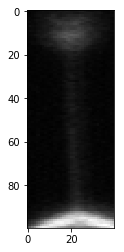

In [5]:
# crop image around vesicle attachment point
# this is necessary because otherwise i will rotate the image and it will rotate it away from my learned attachment points
frames = frames_ch0

frameId = 0
image = frames[frameId]
marginx = 50
marginy = 20
vesiclePoint = [df_analysisResult['vesicle_attachment_x'].iloc[frameId],
                  df_analysisResult['vesicle_attachment_y'].iloc[frameId]]
beadPoint = [df_analysisResult['bead_attachment_x'].iloc[frameId],
                  df_analysisResult['bead_attachment_y'].iloc[frameId]]
#image_centeredOnVesicleAttachmentVector = (image[20:50,10:50])
tubeMidpoint = get_tube_midpoint(vesiclePoint,beadPoint)
print(tubeMidpoint)
midx = int(tubeMidpoint[0])
midy = int(tubeMidpoint[1])
image_centeredOnVesicleAttachmentVector = image[midx-marginx:midx+marginx,midy-marginy:midy+marginy]

plt.imshow(image_centeredOnVesicleAttachmentVector,cmap='gray')

plt.show()

# fit tube to a gaussian for every frame in the movie

In [6]:
def gaussian(B,x):
    ''' Returns the gaussian function for B=m,stdev,max,offset '''
    return B[3]+B[2]/(B[1]*np.sqrt(2*np.pi))*np.exp(-((x-B[0])**2/(2*B[1]**2)))

def errfunc(p,x,y):
    return y-gaussian(p,x)





def fitGaussian(data,p0=[9,3,150,20],verbose=False):
    # p0 = [mean,variance,amplitude,yShift]
    # parameters of our gaussian

    
    
    
    y = data
    x = range(0,len(data))
    
    # initial estimate of parameters 

    fit = optimize.leastsq(errfunc,p0,args=(x,y));
    

    if(verbose):
        plt.plot(x,y,'k-',lw=3)
        plt.plot(x,gaussian(fit[0],x),'r-')
        plt.show()
    
    
    mean = fit[0][0]
    stdev = np.absolute(fit[0][1])
    offset = fit[0][3]
    FWHM = 2.355 * np.absolute(stdev)
    maxx = gaussian(fit[0],mean)
    fitconvergence = fit[1]

    if(verbose):
        print("mean:",mean,"stdev:", stdev,"max:", maxx,"FWHM:",FWHM,"offset:",offset)
        print("fit parameters: mean: {} variance: {} amplitude: {} yshift: {}".format(fit[0][0],fit[0][1],fit[0][2],fit[0][3]))
    return(np.array([mean,stdev,fit[0][2],offset,maxx,maxx-offset,FWHM,fitconvergence]))

[ 82.  70.]
75.0266619276
30 30


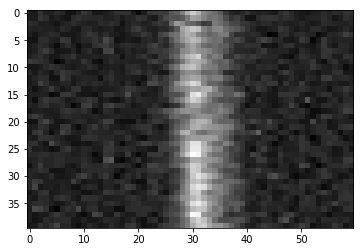

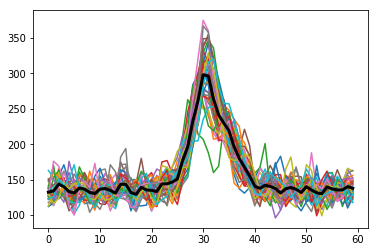

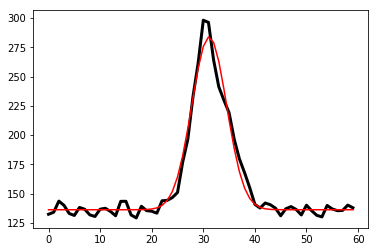

mean: 31.1394662817 stdev: 3.365839425 max: 283.941962556 FWHM: 7.92655184588 offset: 136.237131501
fit parameters: mean: 31.139466281737267 variance: 3.3658394250010937 amplitude: 1246.172110734114 yshift: 136.23713150092323
I_tube_exp 147.704831055 I_vesicle_exp 1605.66666667


NameError: name 'calculateTubeRadius' is not defined

In [7]:
# crop image around vesicle attachment point
# this is necessary because otherwise i will rotate the image and it will rotate it away from my learned attachment points



frames = frames_ch0

frameId = 0
image = frames[frameId]
marginx = 20
marginy = -1 # will be calculated from tube length

#image_centeredOnVesicleAttachmentVector = (image[20:50,10:50])
vesiclePoint = [df_analysisResult['vesicle_attachment_x'].iloc[frameId],
                  df_analysisResult['vesicle_attachment_y'].iloc[frameId]]
beadPoint = [df_analysisResult['bead_attachment_x'].iloc[frameId],
                  df_analysisResult['bead_attachment_y'].iloc[frameId]]
#image_centeredOnVesicleAttachmentVector = (image[20:50,10:50])
tubeMidpoint = get_tube_midpoint(vesiclePoint,beadPoint)
print(tubeMidpoint)

tubeLength = get_tube_length(vesiclePoint,beadPoint)
print(tubeLength)
marginy = int(0.8*tubeLength/2)
print(marginy,marginy)

midx = int(tubeMidpoint[0])
midy = int(tubeMidpoint[1])
image_centeredOnVesicleAttachmentVector = image[midx-marginx:midx+marginx,midy-marginy:midy+marginy]

plt.imshow(image_centeredOnVesicleAttachmentVector,cmap='gray')

plt.show()


for line in image_centeredOnVesicleAttachmentVector:
    plt.plot(line)

plt.plot(np.average(image_centeredOnVesicleAttachmentVector,axis=0),color='k',lw=3)    
plt.show()

averagedIntensity = np.average(image_centeredOnVesicleAttachmentVector,axis=0)
# guess that the center sits on the max                               
guess_mean = np.argmax(averagedIntensity)
# guess that the variance is where the halfmax is
halfmax = np.max(averagedIntensity)-np.min(averagedIntensity)/2
# get the indexes of the elements to the right of the maximum that are larger than the halfmax
indexes = [i for i,v in enumerate(averagedIntensity[guess_mean:-1]) if v > halfmax]
# the length of that list is our sigma guess
guess_sigma = len(indexes)

# our guess for the y-shift is the minimum of the averaged traces
guess_yShift = np.min(averagedIntensity)

# out guess for the amplitude is the difference between min and max of the trace
guess_amplitude = halfmax*2


                               
                               
                               
        
# do the fit:
                               
p0_guess = [guess_mean,guess_sigma,guess_amplitude,guess_yShift];
#print("p0_guess: mean: {} variance: {} amplitude: {} yshift: {}".format(guess_mean,guess_sigma,guess_amplitude,guess_yShift))
fit = fitGaussian(averagedIntensity,p0=p0_guess,verbose=True);


amplitude = fit[5] #maxx-offset


####

I_tube_exp = amplitude
I_vesicle_exp = np.average([1314, 1503, 2000])
print("I_tube_exp",I_tube_exp,"I_vesicle_exp",I_vesicle_exp)

tubeRadius = np.round(calculateTubeRadius(I_tube_exp,I_vesicle_exp),decimals=2)
print("tubeRadius: {}nm".format(tubeRadius))

In [7]:
# do this for the whole movie

In [69]:
# crop image around vesicle attachment point
# this is necessary because otherwise i will rotate the image and it will rotate it away from my learned attachment points
frames = frames_ch0

fits = []

counter = 0
#for frameId in range(0,10):
for frameId in range(0,len(frames)):
    
    if(counter%10==0):
        print(counter)
    try:
        image = frames[frameId]
        marginx = 20
        marginy = -1 # will be calculated from tube length
        
        #image_centeredOnVesicleAttachmentVector = (image[20:50,10:50])
        vesiclePoint = [df_analysisResult['vesicle_attachment_x'].iloc[frameId],
                          df_analysisResult['vesicle_attachment_y'].iloc[frameId]]
        beadPoint = [df_analysisResult['bead_attachment_x'].iloc[frameId],
                          df_analysisResult['bead_attachment_y'].iloc[frameId]]
        #image_centeredOnVesicleAttachmentVector = (image[20:50,10:50])
        tubeMidpoint = get_tube_midpoint(vesiclePoint,beadPoint)
        #print(tubeMidpoint)
        
        tubeLength = get_tube_length(vesiclePoint,beadPoint)
        #print(tubeLength)
        marginy = int(0.8*tubeLength/2)
        #print(marginy,marginy)
        
        midx = int(tubeMidpoint[0])
        midy = int(tubeMidpoint[1])
        image_centeredOnVesicleAttachmentVector = image[midx-marginx:midx+marginx,midy-marginy:midy+marginy]
    
        if(False):
            plt.imshow(image_centeredOnVesicleAttachmentVector,cmap='gray')
            plt.show()
        
        if(False):
            for line in image_centeredOnVesicleAttachmentVector:
                plt.plot(line)
            plt.plot(np.average(image_centeredOnVesicleAttachmentVector,axis=0),color='k',lw=3)    
            plt.show()
        
        averagedIntensity = np.average(image_centeredOnVesicleAttachmentVector,axis=0)
        # guess that the center sits on the max                               
        guess_mean = np.argmax(averagedIntensity)
        # guess that the variance is where the halfmax is
        halfmax = np.max(averagedIntensity)-np.min(averagedIntensity)/2
        # get the indexes of the elements to the right of the maximum that are larger than the halfmax
        indexes = [i for i,v in enumerate(averagedIntensity[guess_mean:-1]) if v > halfmax]
        # the length of that list is our sigma guess
        guess_sigma = len(indexes)
        
        # our guess for the y-shift is the minimum of the averaged traces
        guess_yShift = np.min(averagedIntensity)
        
        # out guess for the amplitude is the difference between min and max of the trace
        guess_amplitude = halfmax*2
        
        
                                       
                                       
                                       
                
        
                                       
        p0_guess = [guess_mean,guess_sigma,guess_amplitude,guess_yShift];
        if(False):
            print("p0_guess: mean: {} variance: {} amplitude: {} yshift: {}".format(guess_mean,guess_sigma,guess_amplitude,guess_yShift))
       
        fit = fitGaussian(averagedIntensity,p0=p0_guess,verbose=False);
    except (TypeError, ZeroDivisionError,IndexError) as e:
        fit = np.array([])
    fits.append(fit)
    counter = counter +1
    
    

fits = np.array(fits)

#df = pd.DataFrame(fits.tolist())
#df.to_csv("./output3/tube_gaussian_fit_data.csv",header=['mean','stdev','fit[0][2]','offset','maxx','maxx-offset','FWHM','fitconvergence'])

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410


/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/ipykernel_launche

420
430
440
450


/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)


460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740


/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:1110: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)


750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270


/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720


# calculate the radius from the tube intensity 

NameError: name 'pnt1' is not defined

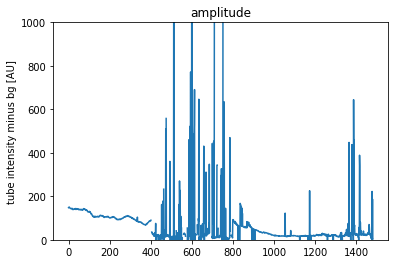

In [8]:
df_tubeFitting = pd.read_csv("./output3/tube_gaussian_fit_data.csv")


plt.plot(df_tubeFitting['maxx-offset'])
plt.title('amplitude')
plt.ylim(0,1000)
plt.ylabel('tube intensity minus bg [AU]')


#pnt1 = 553
#pnt2 = 563
#plt.axvline(pnt1,c='k')
#plt.axvline(pnt2,c='k')
avgAmplitudeInWindow = np.round(np.average(df_tubeFitting['maxx-offset'][pnt1:pnt2]),decimals=2)
stdAmplitudeInWindow = np.round(np.std(df_tubeFitting['maxx-offset'][pnt1:pnt2]),decimals=2)
print("average amplitude window[{}:{}]: {} ± {}".format(pnt1,pnt2,avgAmplitudeInWindow,stdAmplitudeInWindow))

In [9]:
def calculateTubeRadius(I_tube,I_vesicle):
    prefactorForTubeRadius = 161 #nm
    interceptForTubeRadius = 4.4
#    prefactorForTubeRadius = 156.9 #161 #nm
#    interceptForTubeRadius = 10.6 #4.4
    print(I_tube/I_vesicle)
    return interceptForTubeRadius + prefactorForTubeRadius * I_tube/I_vesicle

[ 0.09198972  0.09266009  0.09298764 ...,         nan         nan
         nan]


Text(0.5,0,'time [frames]')

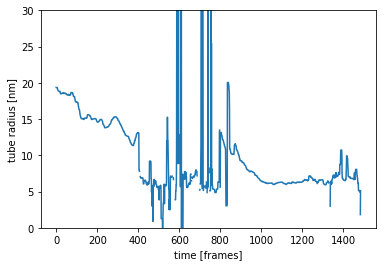

In [10]:
I_tube_exp = df_tubeFitting['maxx-offset'].values;

I_vesicle_exp = np.average([1314, 1503, 2000]);
#print("I_tube_exp",I_tube_exp,"I_vesicle_exp",I_vesicle_exp)

tubeRadius = np.round(calculateTubeRadius(I_tube_exp,I_vesicle_exp),decimals=2);
#print("tubeRadius: {}nm".format(tubeRadius))
plt.plot(scipy.ndimage.median_filter(tubeRadius,10));
plt.ylim(0,30)
plt.ylabel('tube radius [nm]')
plt.xlabel('time [frames]')

[ 0.09198972  0.09266009  0.09298764 ...,         nan         nan
         nan]


/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


Text(0.5,0,'time [frames]')

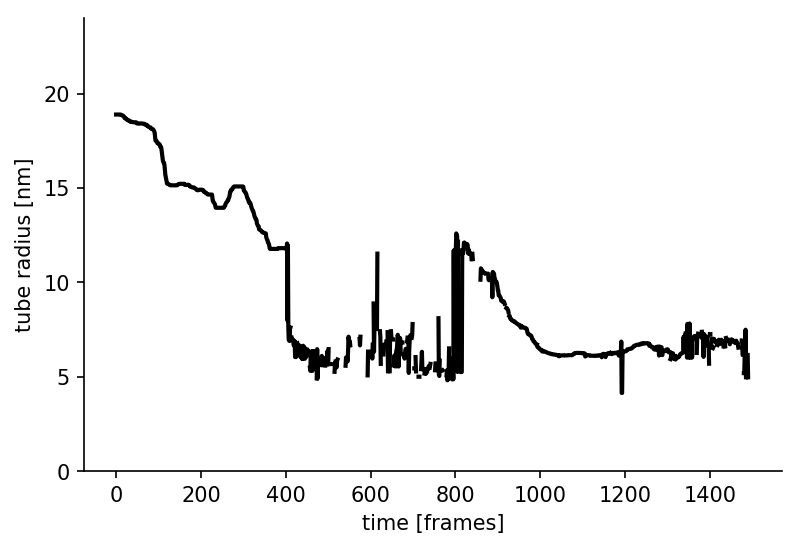

In [11]:
I_tube_exp = df_tubeFitting['maxx-offset'].values;


I_vesicle_exp = np.average([1314, 1503, 2000]);
#print("I_tube_exp",I_tube_exp,"I_vesicle_exp",I_vesicle_exp)

tubeRadius_raw = np.round(calculateTubeRadius(I_tube_exp,I_vesicle_exp),decimals=2);
tubeRadius = tubeRadius_raw
tubeRadius[tubeRadius > 20] = np.nan
tubeRadius[tubeRadius < 4] = np.nan
#print("tubeRadius: {}nm".format(tubeRadius))
plt.figure(dpi=150)
plt.plot(scipy.ndimage.median_filter(tubeRadius,40),lw=2,c='k');
plt.ylim(0,24)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.ylabel('tube radius [nm]')
plt.xlabel('time [frames]')


[ 0.09198972  0.09266009  0.09298764 ...,         nan         nan
         nan]


(0, 24)

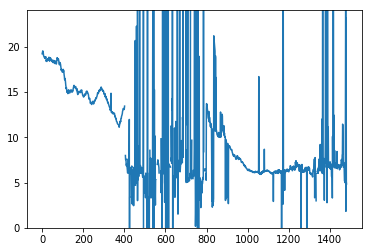

In [12]:
tubeRadius_raw = np.round(calculateTubeRadius(I_tube_exp,I_vesicle_exp),decimals=2);
plt.plot(tubeRadius_raw)
plt.ylim(0,24)

In [13]:
# http://nickc1.github.io/python,/matlab/2016/05/17/Standard-Deviation-(Filters)-in-Matlab-and-Python.html
from scipy.ndimage.filters import uniform_filter

def window_stdev(X, window_size):
    r,c = X.shape
    X+=np.random.rand(r,c)*1e-6
    c1 = uniform_filter(X, window_size, mode='reflect')
    c2 = uniform_filter(X*X, window_size, mode='reflect')
    return np.sqrt(c2 - c1*c1)

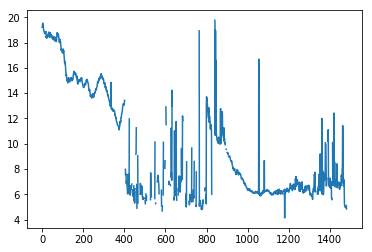

In [14]:
plt.plot(tubeRadius)

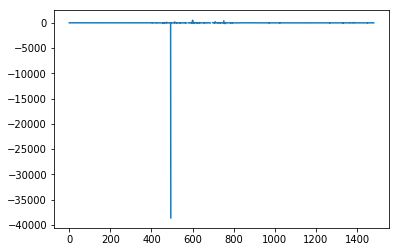

In [15]:
plt.plot(tubeRadius_raw)

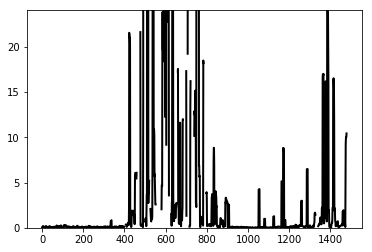

(0, 100)

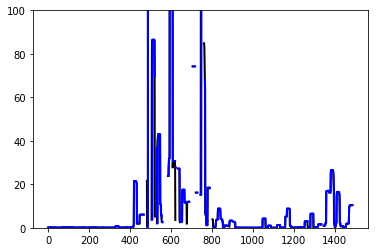

In [16]:
from scipy.ndimage.filters import generic_filter
movingStandardDeviation_tubeRadius = generic_filter(tubeRadius_raw, np.std, size=5)
plt.plot(movingStandardDeviation_tubeRadius,lw=2,c='k');
plt.ylim(0,24)
plt.show()

movingStandardDeviation_tubeRadius = generic_filter(tubeRadius_raw, np.std, size=5)
plt.plot(scipy.ndimage.maximum_filter(movingStandardDeviation_tubeRadius,10),lw=2,c='k');
plt.plot(scipy.ndimage.median_filter(scipy.ndimage.maximum_filter(movingStandardDeviation_tubeRadius,10),10),lw=2,c='b');
plt.ylim(0,100)

In [17]:
plt.figure(dpi=150)

In [18]:
time = -67 + np.arange(0,len(I_tube_exp))*0.333
print(time)

[ -67.     -66.667  -66.334 ...,  505.76   506.093  506.426]


[ 0.09198972  0.09266009  0.09298764 ...,         nan         nan
         nan]
[ 0.09198972  0.09266009  0.09298764 ...,         nan         nan
         nan]


/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in less


AttributeError: 'AxesSubplot' object has no attribute 'spinebs'

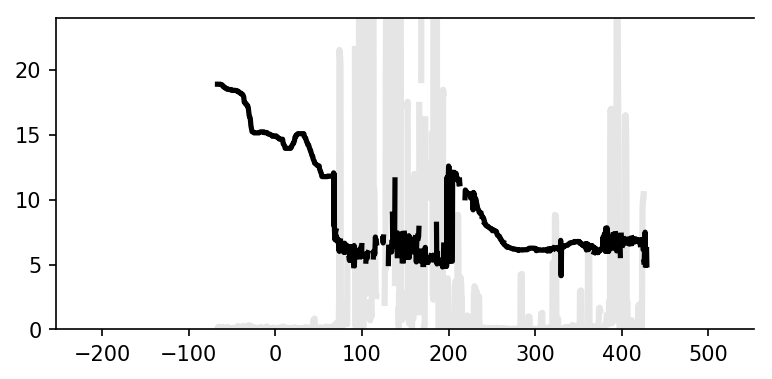

In [19]:

plt.figure(dpi=150)
plt.gca().set_aspect(15)
#
tubeRadius_raw = np.round(calculateTubeRadius(I_tube_exp,I_vesicle_exp),decimals=2);

#generic standard deviation filter on a window
from scipy.ndimage.filters import generic_filter
movingStandardDeviation_tubeRadius = generic_filter(tubeRadius_raw, np.std, size=5)
plt.plot(time,movingStandardDeviation_tubeRadius,lw=3,c='grey',alpha=0.2);
plt.ylim(0,24)



#####

I_tube_exp = df_tubeFitting['maxx-offset'].values;


I_vesicle_exp = np.average([1314, 1503, 2000]);
#print("I_tube_exp",I_tube_exp,"I_vesicle_exp",I_vesicle_exp)

tubeRadius_raw = np.round(calculateTubeRadius(I_tube_exp,I_vesicle_exp),decimals=2);
tubeRadius = tubeRadius_raw
tubeRadius[tubeRadius > 20] = np.nan
tubeRadius[tubeRadius < 4] = np.nan
#print("tubeRadius: {}nm".format(tubeRadius))

plt.plot(time,scipy.ndimage.median_filter(tubeRadius,40),lw=2.5,c='k');
plt.ylim(0,24)

plt.xlim(-253.5,552.5)
plt.gca().spines['right'].set_visible(False)
plt.gca().spinebs['top'].set_visible(False)
plt.ylabel('tube radius [nm]')
plt.xlabel('time [frames]')



In [22]:
df = pd.DataFrame({'time': time, 'radius[nm]': scipy.ndimage.median_filter(tubeRadius,40)})
df.to_csv("./output3/tube_radius_over_time.csv")
df[0:10]

,radius[nm],time
0,18.89,-67.000
1,18.89,-66.667
2,18.89,-66.334
3,18.89,-66.001
4,18.89,-65.668
5,18.89,-65.335
6,18.89,-65.002
7,18.89,-64.669
8,18.89,-64.336
9,18.89,-64.003
